In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import warnings


# Income Prediction Project

## Objective
Predict whether an individual earns more than $50K per year based on features such as age, education level, occupation, marital status, and hours worked per week.

## Features Used
- Age
- Education Level (education.num)
- Occupation
- Marital Status
- Hours Worked per Week
- Work Class
- Race
- Sex
- Native Country
- Capital Gain/Loss

## Model
Random Forest Classifier is used for this prediction task due to its ability to:
- Handle both numerical and categorical features
- Capture non-linear relationships
- Provide feature importance analysis
- Handle complex interactions between features

In [2]:
# Load the data
df = pd.read_csv('adult.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (32561, 15)

First few rows:
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1 

In [11]:
# Basic dataset info
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nData Types:")
print(df.dtypes)
print("\nChecking Duplicate rows")
print(df.duplicated().sum)
print("\nMissing Values:")
print(df.isnull().sum())

# Check for '?' values which represent missing data
print("\n'?' Values (missing data):")
for col in df.columns:
    if df[col].dtype == 'object':
        missing_count = (df[col] == '?').sum()
        if missing_count > 0:
            print(f"{col}: {missing_count}")


print(df.describe())

=== DATASET OVERVIEW ===
Shape: (32561, 15)
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

Data Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

Checking Duplicate rows
<bound method Series.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Length: 32561, dtype: bool>

Missing Values:
age               0
workclass         0
fnlwgt            0
education         0


# Data Preprocessing


In [6]:
# Data Preprocessing
def preprocess_data(df):
    df_clean = df.copy()
    
    # Replace '?' with NaN and then handle missing values
    df_clean = df_clean.replace('?', np.nan)
    
    # Drop rows with missing values in key columns
    columns_to_check = ['workclass', 'occupation', 'native.country']
    df_clean = df_clean.dropna(subset=columns_to_check)
    
    # Handle target variable
    df_clean['income'] = df_clean['income'].str.strip()
    
    return df_clean

df_clean = preprocess_data(df)
print(f"Data shape after cleaning: {df_clean.shape}")

# Check target distribution
print("\n=== TARGET DISTRIBUTION ===")
print(df_clean['income'].value_counts())
print(f"Proportion: {df_clean['income'].value_counts(normalize=True)}")

Data shape after cleaning: (30162, 15)

=== TARGET DISTRIBUTION ===
income
<=50K    22654
>50K      7508
Name: count, dtype: int64
Proportion: income
<=50K    0.751078
>50K     0.248922
Name: proportion, dtype: float64


# Feature Engineering and Encoding

In [7]:
# Feature Engineering and Encoding
def prepare_features(df):
    df_prep = df.copy()
    
    # Drop fnlwgt (not useful for prediction)
    df_prep = df_prep.drop('fnlwgt', axis=1)
    
    # Encode target variable
    le_target = LabelEncoder()
    df_prep['income_encoded'] = le_target.fit_transform(df_prep['income'])
    
    # Separate features
    numerical_features = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 
                           'relationship', 'race', 'sex', 'native.country']
    
    # Handle categorical features - using OneHotEncoding for low cardinality, LabelEncoding for high
    categorical_data = pd.DataFrame()
    
    # OneHot Encoding for lower cardinality features
    ohe_columns = ['workclass', 'marital.status', 'relationship', 'race', 'sex']
    for col in ohe_columns:
        dummies = pd.get_dummies(df_prep[col], prefix=col, drop_first=True)
        categorical_data = pd.concat([categorical_data, dummies], axis=1)
    
    # Label Encoding for higher cardinality features to avoid too many dimensions
    le = LabelEncoder()
    categorical_data['occupation_encoded'] = le.fit_transform(df_prep['occupation'])
    categorical_data['education_encoded'] = le.fit_transform(df_prep['education'])
    categorical_data['native.country_encoded'] = le.fit_transform(df_prep['native.country'])
    
    # Combine all features
    X_numerical = df_prep[numerical_features]
    X_final = pd.concat([X_numerical, categorical_data], axis=1)
    y_final = df_prep['income_encoded']
    
    return X_final, y_final, numerical_features

X, y, numerical_features = prepare_features(df_clean)
print(f"Final feature shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

Final feature shape: (30162, 30)
Features: ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'marital.status_Married-AF-spouse', 'marital.status_Married-civ-spouse', 'marital.status_Married-spouse-absent', 'marital.status_Never-married', 'marital.status_Separated', 'marital.status_Widowed', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White', 'sex_Male', 'occupation_encoded', 'education_encoded', 'native.country_encoded']


# Split the Data

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

Training set: (21113, 30)
Test set: (9049, 30)
Training target distribution: [15857  5256]
Test target distribution: [6797 2252]


# Train model


In [9]:
# Train baseline model (before tuning)
def train_baseline_model(X_train, X_test, y_train, y_test):
    print("\n=== Training Baseline Random Forest (Before Tuning) ===")
    
    # Initialize baseline model with default parameters
    baseline_model = RandomForestClassifier(random_state=42)
    
    # Train model
    baseline_model.fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)
    y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    baseline_results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': baseline_model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print("\n=== Baseline Model Performance Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\n=== Baseline Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))
    
    return baseline_results

# Get baseline model results
baseline_results = train_baseline_model(X_train, X_test, y_train, y_test)


=== Training Baseline Random Forest (Before Tuning) ===

=== Baseline Model Performance Metrics ===
Accuracy: 0.8500
Precision: 0.7294
Recall: 0.6319
F1-Score: 0.6771
ROC-AUC: 0.8964

=== Baseline Classification Report ===
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      6797
        >50K       0.73      0.63      0.68      2252

    accuracy                           0.85      9049
   macro avg       0.81      0.78      0.79      9049
weighted avg       0.84      0.85      0.85      9049


=== Baseline Model Performance Metrics ===
Accuracy: 0.8500
Precision: 0.7294
Recall: 0.6319
F1-Score: 0.6771
ROC-AUC: 0.8964

=== Baseline Classification Report ===
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      6797
        >50K       0.73      0.63      0.68      2252

    accuracy                           0.85      9049
   macro avg       0.81      0.78      0.79      9049
weighted a

# Hyperparameter Tuning

In [10]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train, y_train):
    # Optimized parameter grid 
    param_grid = {
        'n_estimators': [100, 200],        # fewer trees for faster tuning
        'max_depth': [10, 20, None],       # controls tree depth
        'min_samples_split': [2, 5],       # typical split thresholds
        'min_samples_leaf': [1, 2],        # helps prevent overfitting
        'max_features': ['sqrt'],          # best for classification tasks
        'criterion': ['gini']              # gini is faster than entropy
    }

    # Create the model
    rf = RandomForestClassifier(random_state=42)

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )

    # Fit the grid search
    print("Starting Optimized Grid Search...")
    grid_search.fit(X_train, y_train)

    # Print results
    print("\n=== Grid Search Results ===")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Get detailed CV results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.sort_values('rank_test_score')

    print("\nTop 5 Parameter Combinations:")
    columns_to_show = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    print(cv_results[columns_to_show].head())

    return grid_search.best_estimator_

# Perform hyperparameter tuning
print("=== Hyperparameter Tuning for Random Forest (Optimized) ===")
best_rf_model = tune_random_forest(X_train, y_train)

   

=== Hyperparameter Tuning for Random Forest (Optimized) ===
Starting Optimized Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Grid Search Results ===
Best parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9136

Top 5 Parameter Combinations:
                                               params  mean_test_score  \
13  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.913572   
15  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.913457   
14  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.913147   
12  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.913070   
23  {'criterion': 'gini', 'max_depth': None, 'max_...         0.912680   

    std_test_score  rank_test_score  
13        0.003361                1  
15        0.003538                2  
14        0.003302                3  
12 

In [13]:
# Import Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Optimized Hyperparameter Tuning for both Decision Tree and Random Forest
def tune_models(X_train, y_train):
    #  Optimized Decision Tree Parameters
    dt_param_grid = {
        'max_depth': [10, 20, None],             # only essential depths
        'min_samples_split': [2, 5],             # common split sizes
        'min_samples_leaf': [1, 2],              # prevents overfitting
        'criterion': ['gini'],                   # gini is faster than entropy
        'splitter': ['best'],                    # "best" works well generally
        'max_features': ['sqrt', None]           # fewer options → faster search
    }
    
    #  Optimized Random Forest Parameters
    rf_param_grid = {
        'n_estimators': [100, 200],              # fewer forests → faster
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],                # best for classification
        'criterion': ['gini'],                   # faster, minimal loss vs entropy
        'bootstrap': [True]                      # default and stable
    }
    
    # Initialize models
    dt = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42)
    
    # GridSearchCV objects
    dt_grid = GridSearchCV(
        estimator=dt,
        param_grid=dt_param_grid,
        cv=3,                # reduced from 5 → 3x faster
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    rf_grid = GridSearchCV(
        estimator=rf,
        param_grid=rf_param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    # === Decision Tree ===
    print("\n=== Decision Tree Hyperparameter Tuning (Optimized) ===")
    dt_grid.fit(X_train, y_train)
    print("\nBest Decision Tree Parameters:")
    print(dt_grid.best_params_)
    print(f"Best Decision Tree Score: {dt_grid.best_score_ * 100:.2f}%")
    
    # === Random Forest ===
    print("\n=== Random Forest Hyperparameter Tuning (Optimized) ===")
    rf_grid.fit(X_train, y_train)
    print("\nBest Random Forest Parameters:")
    print(rf_grid.best_params_)
    print(f"Best Random Forest Score: {rf_grid.best_score_ * 100:.2f}%")
    
    return dt_grid.best_estimator_, rf_grid.best_estimator_

# Run tuning
print("=== Optimized Hyperparameter Tuning for Decision Tree & Random Forest ===")
best_dt, best_rf = tune_models(X_train, y_train)


=== Optimized Hyperparameter Tuning for Decision Tree & Random Forest ===

=== Decision Tree Hyperparameter Tuning (Optimized) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Decision Tree Parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Best Decision Tree Score: 88.37%

=== Random Forest Hyperparameter Tuning (Optimized) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Decision Tree Parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Best Decision Tree Score: 88.37%

=== Random Forest Hyperparameter Tuning (Optimized) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best

In [14]:
# Train Model with Tuned Hyperparameters
def train_and_evaluate_models(X_train, X_test, y_train, y_test, best_model):
    print("\n=== Training Random Forest with Tuned Hyperparameters ===")
    
    # Train model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results = {
        'Random Forest': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'model': best_model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    }
    
    print("\n=== Model Performance Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))
    
    return results

# Train and evaluate model with best hyperparameters
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, best_rf_model)


=== Training Random Forest with Tuned Hyperparameters ===

=== Model Performance Metrics ===
Accuracy: 0.8645
Precision: 0.7885
Recall: 0.6226
F1-Score: 0.6958
ROC-AUC: 0.9206

=== Classification Report ===
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      6797
        >50K       0.79      0.62      0.70      2252

    accuracy                           0.86      9049
   macro avg       0.84      0.78      0.80      9049
weighted avg       0.86      0.86      0.86      9049


=== Model Performance Metrics ===
Accuracy: 0.8645
Precision: 0.7885
Recall: 0.6226
F1-Score: 0.6958
ROC-AUC: 0.9206

=== Classification Report ===
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      6797
        >50K       0.79      0.62      0.70      2252

    accuracy                           0.86      9049
   macro avg       0.84      0.78      0.80      9049
weighted avg       0.86      0.86      0.86 

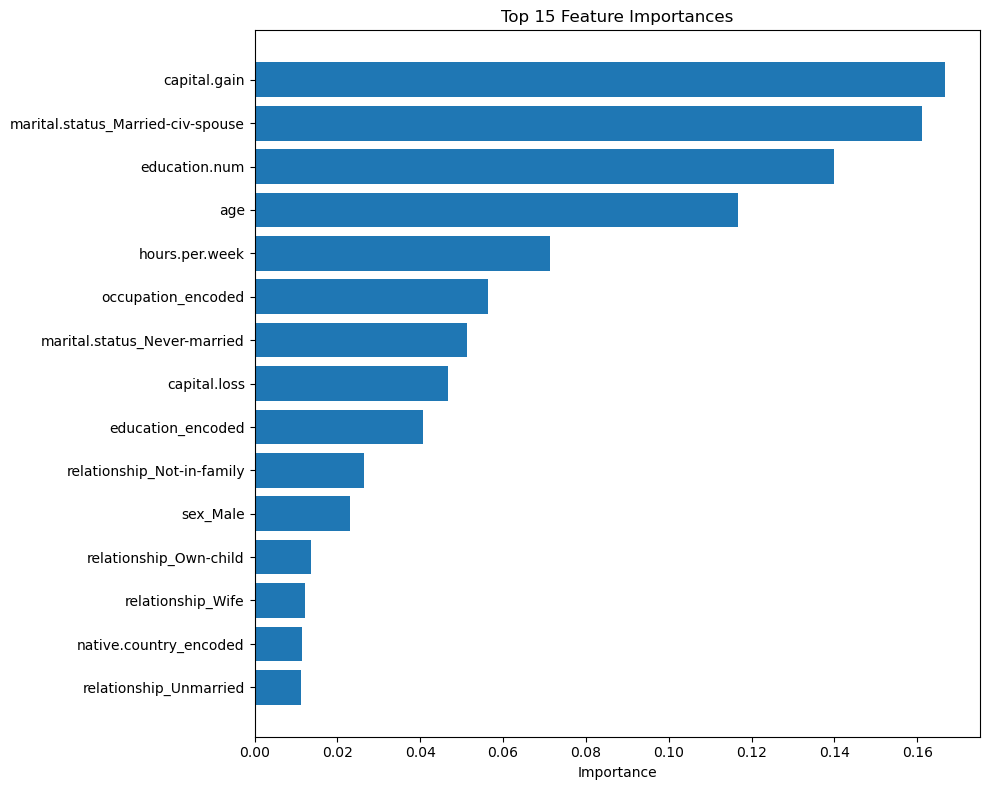


Top 15 Most Important Features:
1. capital.gain: 0.1668
2. marital.status_Married-civ-spouse: 0.1612
3. education.num: 0.1399
4. age: 0.1167
5. hours.per.week: 0.0712
6. occupation_encoded: 0.0564
7. marital.status_Never-married: 0.0513
8. capital.loss: 0.0466
9. education_encoded: 0.0408
10. relationship_Not-in-family: 0.0264
11. sex_Male: 0.0230
12. relationship_Own-child: 0.0136
13. relationship_Wife: 0.0122
14. native.country_encoded: 0.0114
15. relationship_Unmarried: 0.0113


In [16]:
# Feature Importance Analysis
def plot_feature_importance(model, feature_names, top_n=15):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 8))
        plt.title(f"Top {top_n} Feature Importances")
        plt.barh(range(top_n), importances[indices[:top_n]][::-1])
        plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop {top_n} Most Important Features:")
        for i in range(top_n):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot feature importance for Random Forest
rf_model = results['Random Forest']['model']
plot_feature_importance(rf_model, X.columns.tolist())
def plot_evaluation_metrics(results, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot confusion matrix
    name = 'Random Forest'
    result = results[name]
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['<=50K', '>50K'], 
               yticklabels=['<=50K', '>50K'], 
               ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {result["roc_auc"]:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {name}')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

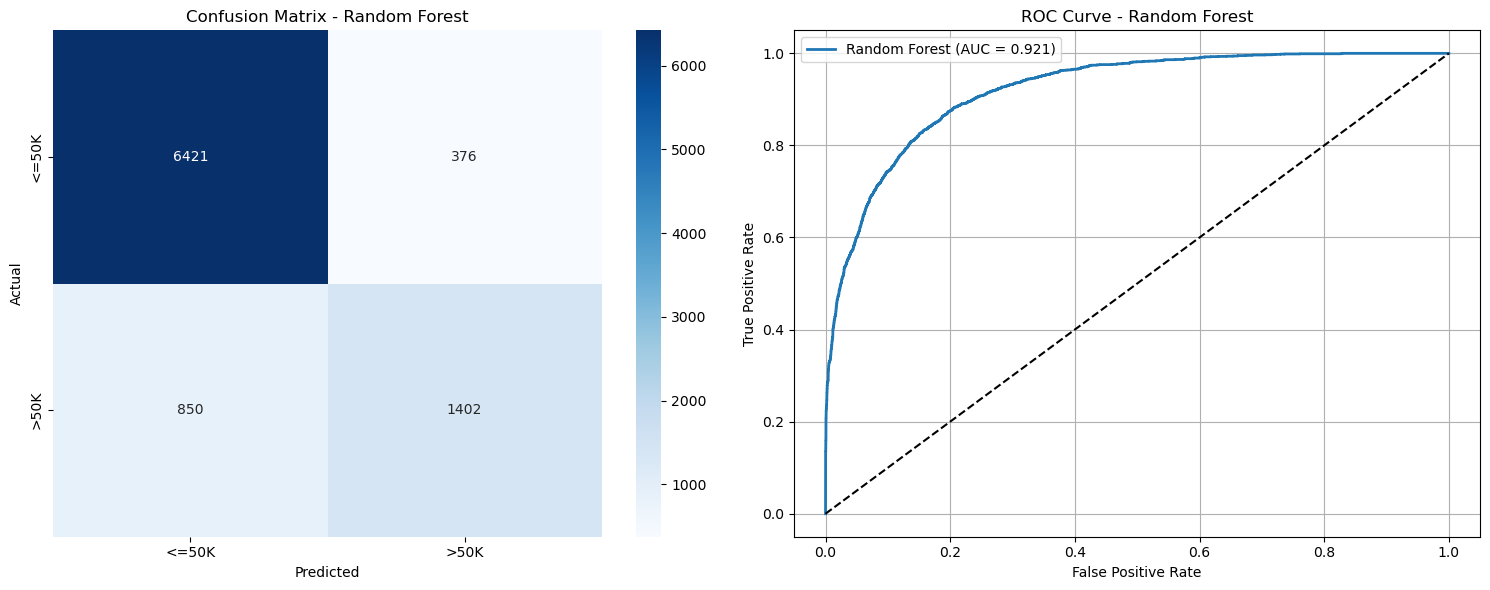

In [17]:
# Visualization: Confusion Matrix and ROC Curve
def plot_evaluation_metrics(results, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot confusion matrix
    name = 'Random Forest'
    result = results[name]
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['<=50K', '>50K'], 
               yticklabels=['<=50K', '>50K'], 
               ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {result["roc_auc"]:.3f})')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {name}')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_evaluation_metrics(results, y_test)

In [18]:
# Results Summary
print("=== MODEL PERFORMANCE ===")
model_name = 'Random Forest'
result = results[model_name]
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Score': [result['accuracy'], 
             result['precision'], 
             result['recall'], 
             result['f1'], 
             result['roc_auc']]
})
print(metrics.set_index('Metric').round(4))

=== MODEL PERFORMANCE ===
            Score
Metric           
Accuracy   0.8645
Precision  0.7885
Recall     0.6226
F1-Score   0.6958
ROC-AUC    0.9206


=== Model Performance Comparison ===

Metrics Comparison:
           Baseline Model  Tuned Model
accuracy           0.8500       0.8645
precision          0.7294       0.7885
recall             0.6319       0.6226
f1                 0.6771       0.6958
roc_auc            0.8964       0.9206

Performance Improvement:
           Absolute Improvement  Relative Improvement (%)
accuracy                 0.0145                    1.7031
precision                0.0592                    8.1107
recall                  -0.0093                   -1.4758
f1                       0.0186                    2.7537
roc_auc                  0.0242                    2.7001


<Figure size 1200x600 with 0 Axes>

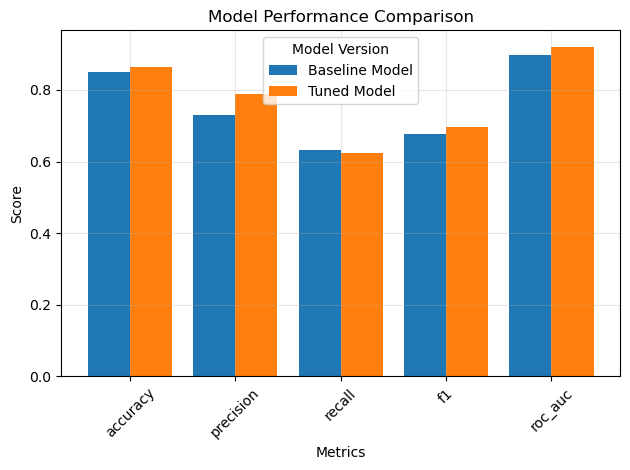

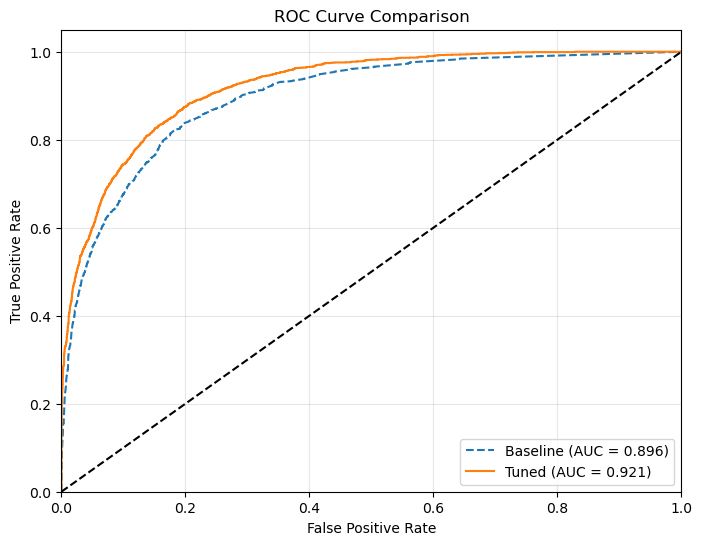


=== Feature Importance Comparison ===


<Figure size 1200x600 with 0 Axes>

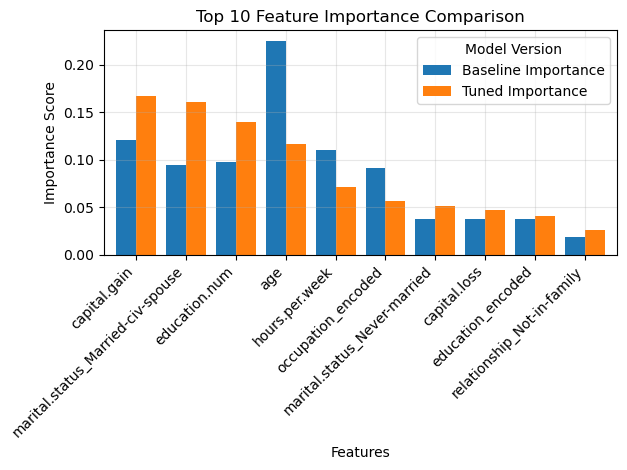


Feature Importance Comparison:
                                   Baseline Importance  Tuned Importance
capital.gain                                    0.1203            0.1668
marital.status_Married-civ-spouse               0.0943            0.1612
education.num                                   0.0979            0.1399
age                                             0.2250            0.1167
hours.per.week                                  0.1107            0.0712
occupation_encoded                              0.0911            0.0564
marital.status_Never-married                    0.0377            0.0513
capital.loss                                    0.0371            0.0466
education_encoded                               0.0371            0.0408
relationship_Not-in-family                      0.0186            0.0264


In [21]:
# Compare baseline and tuned model performance
def compare_models(baseline_results, tuned_results):
    # Create comparison dataframe
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    comparison_df = pd.DataFrame({
        'Baseline Model': [baseline_results[metric] for metric in metrics],
        'Tuned Model': [tuned_results['Random Forest'][metric] for metric in metrics]
    }, index=metrics)
    
    # Calculate improvement
    improvement = pd.DataFrame({
        'Absolute Improvement': comparison_df['Tuned Model'] - comparison_df['Baseline Model'],
        'Relative Improvement (%)': ((comparison_df['Tuned Model'] - comparison_df['Baseline Model']) / 
                                   comparison_df['Baseline Model'] * 100)
    })
    
    # Print comparison
    print("=== Model Performance Comparison ===")
    print("\nMetrics Comparison:")
    print(comparison_df.round(4))
    
    print("\nPerformance Improvement:")
    print(improvement.round(4))
    
    # Visualize comparison
    plt.figure(figsize=(12, 6))
    comparison_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.legend(title='Model Version')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves comparison
    plt.figure(figsize=(8, 6))
    
    # Plot baseline ROC
    fpr_base, tpr_base, _ = roc_curve(y_test, baseline_results['probabilities'])
    plt.plot(fpr_base, tpr_base, 
             label=f'Baseline (AUC = {baseline_results["roc_auc"]:.3f})',
             linestyle='--')
    
    # Plot tuned ROC
    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_results['Random Forest']['probabilities'])
    plt.plot(fpr_tuned, tpr_tuned, 
             label=f'Tuned (AUC = {tuned_results["Random Forest"]["roc_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Compare model performances
compare_models(baseline_results, results)

# Print feature importance comparison
print("\n=== Feature Importance Comparison ===")
def compare_feature_importance(baseline_model, tuned_model, feature_names, top_n=10):
    baseline_importance = pd.Series(baseline_model.feature_importances_, index=feature_names)
    tuned_importance = pd.Series(tuned_model.feature_importances_, index=feature_names)
    
    importance_df = pd.DataFrame({
        'Baseline Importance': baseline_importance,
        'Tuned Importance': tuned_importance
    }).sort_values('Tuned Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))
    importance_df.plot(kind='bar', width=0.8)
    plt.title(f'Top {top_n} Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.legend(title='Model Version')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Compare feature importance
importance_comparison = compare_feature_importance(
    baseline_results['model'],
    results['Random Forest']['model'],
    X.columns
)
print("\nFeature Importance Comparison:")
print(importance_comparison.round(4))